# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1al-kQLtuIb0OvJ-0UIs97DZCpcfVEDlP#scrollTo=l-k2PEshW81f

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import torchtext


## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
zip_ref = zipfile.ZipFile("/content/smsspamcollection.zip", 'r') #Reading the zip file 
zip_ref.extractall() # Extracting the zipped file
zip_ref.close() # closing the file

In [3]:
import re
ham_spam = []
messages = []
for line in open('SMSSpamCollection'):
    first_word = re.split("\s", line)[0]
    rem_words = " ".join(re.split("\s",line)[1:-1])
    ham_spam.append(first_word)
    messages.append(rem_words)

In [4]:
index_spam = ham_spam.index('spam')
index_ham = ham_spam.index('ham')

In [5]:
print(f"Spam Message: {messages[index_spam]}")
print(f"Ham Message: {messages[index_ham]}")

Spam Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Ham Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [6]:
from collections import Counter
print(f"There are {list(Counter(ham_spam).values())[0]} ham messages and {list(Counter(ham_spam).values())[1]} spam messages in the dataset")

There are 4827 ham messages and 747 spam messages in the dataset


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:

1. Most of the text messages are characters rather than formal use of words in sentences, therefore will be able to classify spam / ham better
2. Also, rather than the sequence of words, certain sequence of characters are more representative of the spam messages.

Disadvantages:

1. Too much noise in the dataset, it may learn certain unrepresentative data and can overfit.
2. with Character level RNN, since there are more characters in a data line, it will take longer time to train character level RNN.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                               "tsv",               # fields are separated by a tab
                                               fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

In [8]:
# checking the format of the dataset
print(vars(dataset[0]))

{'label': 0, 'sms': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'}


In [9]:
# checking if the split has happend correctly
total_length = len(dataset)
print(f"Training set split: {round(len(train)/total_length,2)},\nTesting set split: {round(len(test)/total_length,2)},\nvalidation set split: {round(len(valid)/total_length,2)}")

Training set split: 0.6,
Testing set split: 0.2,
validation set split: 0.2


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [10]:
train_spam = [int(1) for i in range(len(train)) if vars(train[i])['label']==int(1)]
print(f"spam percentage in training set: {round((len(train_spam)/len(train))*100,2)}%")

spam percentage in training set: 13.25%


Observation: The available spam collection is very less for training, which may lead to overfitting to the spam collection and the model may not generalise properly, therefore duplicating more training samples.

In [11]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [12]:
print(f"training examples before duplication: {len(old_train_examples)} and after duplication: {len(train)}")

training examples before duplication: 3343 and after duplication: 6001


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [13]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

1. text_field.vocab.itos provides a list mapping indices to tokens.
2. text_field.vocab.stoi provides a dictionary mapping tokens to indices

In [14]:
print(text_field.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f0079913810>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, '5': 30, 'E': 31, 'v': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'x': 39, 'N': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'U': 49, 'W': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'F': 56, 'G': 57, 'Y': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, 'X': 65, ':': 66, 'z': 67, 'V': 68, '*': 69, 'j': 70, 'K': 71, ')': 72, '+': 73, 'J': 74, ';': 75, '(': 76, 'q': 77, 'Q': 78, '"': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, '<': 86, '$': 87, 'Ü': 88, '\x92': 89, '|': 90, '_': 91, '%': 92, '‘': 93, '¡': 94, '…': 95, '’': 96, 'ú': 97, '“':

Observation: Here the tokens are the characters and they are mapped to their respective indices.

In [15]:
print(text_field.vocab.itos)

['<unk>', '<pad>', ' ', 'e', 'o', 't', 'a', 'n', 'r', 'i', 's', 'l', 'u', '0', 'h', 'd', '.', 'm', 'c', 'y', 'w', 'p', 'g', '1', 'f', '2', 'b', '8', 'T', 'k', '5', 'E', 'v', 'S', 'C', 'O', 'I', '4', '7', 'x', 'N', 'A', '3', '6', 'R', '!', ',', 'P', '9', 'U', 'W', 'M', 'L', 'H', 'B', 'D', 'F', 'G', 'Y', "'", '/', '?', '£', '-', '&', 'X', ':', 'z', 'V', '*', 'j', 'K', ')', '+', 'J', ';', '(', 'q', 'Q', '"', '#', '>', '@', '=', 'Z', 'ü', '<', '$', 'Ü', '\x92', '|', '_', '%', '‘', '¡', '…', '’', 'ú', '“', '–', '\\', '~', '\x96', '\t', '\n', '[', ']', '\x94', '^', '\x91', 'è', 'ì', '—']


Observation: its similar to the stoi, but its in the list format, where the index of each characters maps the character in the list.

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

https://pytorch.org/text/stable/vocab.html

1. Unk is a intialization function, where if a character / word which are out of vocabulary occurs, it initializes zero vector to that character / word.

2. Pad represents the token appended to make the length of messages throughout the batches same.

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [16]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [21]:
max_length = []
pad_tokens = []
batches = list(range(11))[1:]
for i, batch in enumerate (train_iter):
  # print(f"For batch: {i+1}")
  max_length.append(int(max(batch.sms[1])))
  pad_tokens.append(int(sum(max(batch.sms[1])-batch.sms[1])))
  if i == 9:
    break
d = {'Batches':batches,'Max_length':max_length,'Pad_tokens':pad_tokens}
pd.DataFrame(d)


,Batches,Max_length,Pad_tokens
0,1,44,24
1,2,71,32
2,3,46,35
3,4,81,30
4,5,155,0
5,6,162,22
6,7,135,41
7,8,132,60
8,9,159,25
9,10,69,37


In [22]:
batch.sms[1]

tensor([69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 68, 68, 68,
        68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66])

In [19]:
print(batch.sms[0][1])

tensor([58,  4, 12,  2, 14,  6, 32,  3,  2, 26,  3,  3,  7,  2, 10,  3, 11,  3,
        18,  5,  3, 15,  2,  5,  4,  2, 10,  5,  6, 19,  2,  9,  7,  2, 23,  2,
         4, 24,  2, 25, 30, 13,  2,  5,  4, 21,  2, 54,  8,  9,  5,  9, 10, 14,
         2, 14,  4,  5,  3, 11, 10,  2, 63,  2, 56, 35, 44,  2, 40, 35, 28, 53,
        36, 40, 57, 45,  2, 53,  4, 11,  9, 15,  6, 19,  2, 50,  4,  8,  5, 14,
         2, 62, 42, 30, 13, 45,  2, 28,  4,  2, 34, 11,  6,  9, 17, 46,  2, 34,
         6, 11, 11,  2, 52,  4,  7, 15,  4,  7,  2, 13, 25, 13, 38, 25, 13, 43,
        48, 37, 13, 13, 16,  2, 54, 39,  2, 30, 25, 43, 46,  2, 33, 50, 38, 42,
        33, 33])


Observation: No pad tokens added

In [23]:
print(batch.sms[0][11])

tensor([35,  8,  2,  9,  2, 22,  4,  2, 14,  4, 17,  3,  2, 24,  9,  8, 10,  5,
         2, 11,  6,  8,  2, 85,  2, 20,  6,  9,  5,  2, 37,  2, 17,  3,  2, 11,
         4,  8, 16, 16,  2, 36,  2, 21, 12,  5,  2, 15,  4, 20,  7,  2, 17, 19,
         2, 10,  5, 12, 24, 24,  2, 24,  9,  8, 10,  5, 16, 16,  1])


Observation: Pad token of 1 is added at the end to match the dimension

In [24]:
print(batch.sms[0][25])

tensor([40,  3,  3, 15,  2,  6,  2, 18,  4, 24, 24,  3,  3,  2,  8, 12,  7,  2,
         5,  4, 17,  4, 61, 34,  6,  7, 59,  5,  2, 26,  3, 11,  9,  3, 32,  3,
         2,  9,  5, 59, 10,  2,  5, 14,  6,  5,  2,  5,  9, 17,  3,  2,  4, 24,
         2, 20,  3,  3, 29,  2,  6, 11,  8,  3,  6, 15, 19,  1,  1])


Observation: pad token 1 has been added to the last two spaces to match the missing values.

## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [25]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [26]:
class sd_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, pooling = False, pool_type = 1):
        super(sd_RNN, self).__init__()
        self.name = 'sd_RNN'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.pooling = pooling
        self.pool_type = pool_type
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.fc2 = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        
        x = self.emb[x]
        # print("first step in network done")
        #h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x)
        # print("got out")

        if self.pooling == False:
          # print("insdie falst")
          out = self.fc(out[:, -1, :])
          return out
        else:
          pass
        if self.pooling == True:
          if self.pool_type ==1:
            # print("inside first loop")
            out = self.fc(torch.max(out, dim=1)[0])
            return out
          elif self.pool_type ==2:
            # print("inside 2nd loop")
            out = torch.cat([torch.max(out, dim=1)[0], 
                            torch.mean(out, dim=1)], dim=1)
            out = self.fc2(out)
            return out

In [27]:
model = sd_RNN(50, 50, 2,pooling=True,pool_type=2)

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [28]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct, total = 0, 0
    for data, labels in data_loader:
        output = model(data[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [29]:
def get_model_name(name, batch_size, learning_rate, epoch,hidden,output):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_hidden{4}_out{5}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   hidden,
                                                   output)
    return path

def train_rnn_network(model, train, valid, hidden, output, num_epochs=5,learning_rate=1e-5, batch_size = 32, plot=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                                        batch_size=batch_size,
                                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                                        sort_within_batch=True,        # sort within each batch
                                                        repeat=False)                  # repeat the iterator for many epochs
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                                        batch_size=batch_size,
                                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                                        sort_within_batch=True,        # sort within each batch
                                                        repeat=False)                  # repeat the iterator for many epochs
    for epoch in range(num_epochs):
        # print("for epoch: ",epoch)
        batch=1
        for data,labels in train_loader:
            # print("batch: ",batch)
            batch += 1
            
            # print("zero gradient")
            pred = model(data[0])
            # print("model generated")
            loss = criterion(pred, labels)
            # print("loss calculated")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch, hidden, output)
        torch.save(model.state_dict(), model_path)
    # plotting
    if plot:
      plt.title("Training Curve")
      plt.plot(losses,'rs-', label="Train", linewidth=1,zorder=4)
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.grid(alpha=0.5, color='k', linestyle='--')
      plt.show()

      plt.title("Training Curve")
      plt.plot(epochs, train_acc,'bo-',label="Train",linewidth=1,zorder=4)
      plt.plot(epochs, valid_acc,'gs-',label="Validation",linewidth=1,zorder=4)
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.grid(alpha=0.5, color='k', linestyle='--')
      plt.show()

Epoch 1; Loss 0.527940; Train Acc 0.516747; Val Acc 0.129148
Epoch 2; Loss 0.510600; Train Acc 0.516747; Val Acc 0.129148
Epoch 3; Loss 0.520292; Train Acc 0.516747; Val Acc 0.129148
Epoch 4; Loss 0.900585; Train Acc 0.516747; Val Acc 0.129148
Epoch 5; Loss 0.975888; Train Acc 0.516747; Val Acc 0.129148


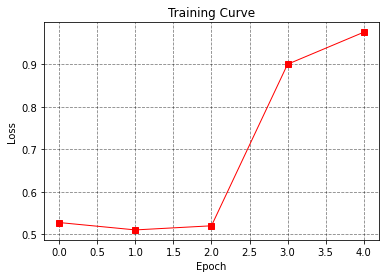

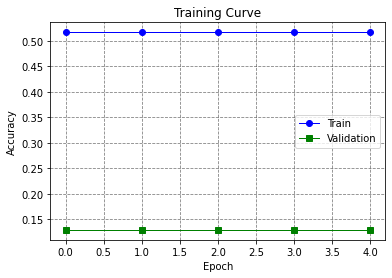

In [30]:
test_model = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2)
train_rnn_network(test_model,train,valid,10,1)

Observation: By checking with the default parameters kept, we can see that model has not trained properly. Therefore by hyper-parameter tuning we will train the model.

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Hyper-parameters to tune: 
1. Learning Rate
2. Epoch
3. Batch-size
4. Output pooling of RNN layer
5. Hidden layer size

Initially lets try to find the best combination of epochs and learning rate

Epoch 1; Loss 0.755194; Train Acc 0.521164; Val Acc 0.145291
Epoch 2; Loss 0.719144; Train Acc 0.529697; Val Acc 0.191031
Epoch 3; Loss 0.633012; Train Acc 0.575372; Val Acc 0.303139
Epoch 4; Loss 0.800540; Train Acc 0.626569; Val Acc 0.547085
Epoch 5; Loss 0.737002; Train Acc 0.623055; Val Acc 0.639462
Epoch 6; Loss 0.673464; Train Acc 0.641626; Val Acc 0.691480
Epoch 7; Loss 0.684842; Train Acc 0.644470; Val Acc 0.704036
Epoch 8; Loss 0.593768; Train Acc 0.684624; Val Acc 0.740807
Epoch 9; Loss 0.668848; Train Acc 0.675924; Val Acc 0.751570
Epoch 10; Loss 0.621516; Train Acc 0.694161; Val Acc 0.770404
Epoch 11; Loss 0.605461; Train Acc 0.717082; Val Acc 0.804484
Epoch 12; Loss 0.529418; Train Acc 0.750711; Val Acc 0.808072
Epoch 13; Loss 0.368584; Train Acc 0.812448; Val Acc 0.869058
Epoch 14; Loss 0.713489; Train Acc 0.848419; Val Acc 0.901345
Epoch 15; Loss 0.182124; Train Acc 0.855780; Val Acc 0.920179
Epoch 16; Loss 0.315843; Train Acc 0.857788; Val Acc 0.932735
Epoch 17; Loss 0.

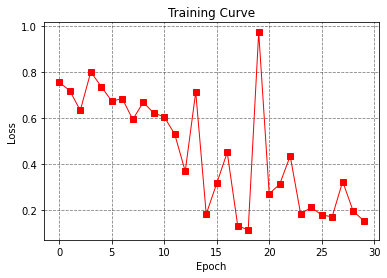

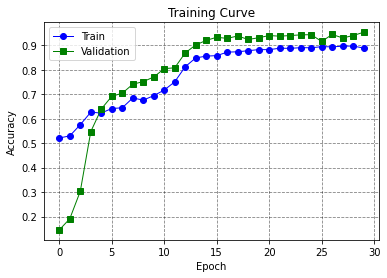

In [278]:
# Increasing the epochs and increasing the learning rate as the previous try, it can be seen that the learning was not proper it was too slow
model_1 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2)
train_rnn_network(model_1,train,valid,10,1,num_epochs=30,learning_rate=0.0001)

Epoch 1; Loss 0.714992; Train Acc 0.672411; Val Acc 0.514798
Epoch 2; Loss 0.249051; Train Acc 0.884056; Val Acc 0.914798
Epoch 3; Loss 0.677056; Train Acc 0.902125; Val Acc 0.926457
Epoch 4; Loss 0.237198; Train Acc 0.913334; Val Acc 0.948879
Epoch 5; Loss 0.378835; Train Acc 0.922536; Val Acc 0.939013
Epoch 6; Loss 0.202441; Train Acc 0.922871; Val Acc 0.952466
Epoch 7; Loss 0.485809; Train Acc 0.852434; Val Acc 0.952466
Epoch 8; Loss 0.122204; Train Acc 0.920361; Val Acc 0.967713
Epoch 9; Loss 0.550242; Train Acc 0.820144; Val Acc 0.927354
Epoch 10; Loss 0.257066; Train Acc 0.854944; Val Acc 0.922870
Epoch 11; Loss 0.256733; Train Acc 0.922034; Val Acc 0.953363
Epoch 12; Loss 0.135712; Train Acc 0.935754; Val Acc 0.955157
Epoch 13; Loss 0.142856; Train Acc 0.913167; Val Acc 0.931839
Epoch 14; Loss 0.454977; Train Acc 0.926384; Val Acc 0.954260
Epoch 15; Loss 0.099496; Train Acc 0.933411; Val Acc 0.950673
Epoch 16; Loss 0.132064; Train Acc 0.939267; Val Acc 0.944395
Epoch 17; Loss 0.

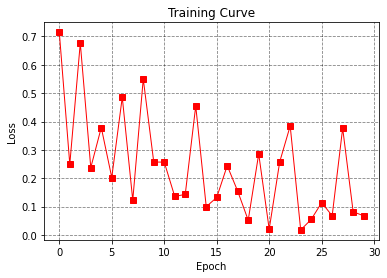

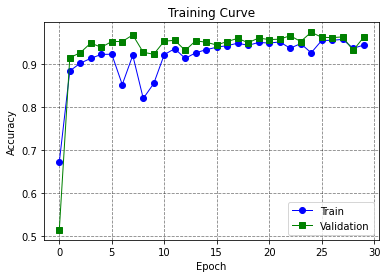

In [279]:
# increasing the epochs and increasing the learning rate definitely improved accuracy, lets try changing the learning rate once more
model_2 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2)
train_rnn_network(model_2,train,valid,10,1,num_epochs=30,learning_rate=0.001)

Epoch 1; Loss 0.378606; Train Acc 0.899448; Val Acc 0.945291
Epoch 2; Loss 0.134696; Train Acc 0.928225; Val Acc 0.959641
Epoch 3; Loss 0.626035; Train Acc 0.702526; Val Acc 0.722870
Epoch 4; Loss 0.869385; Train Acc 0.700519; Val Acc 0.691480
Epoch 5; Loss 0.185847; Train Acc 0.873850; Val Acc 0.899552
Epoch 6; Loss 0.554838; Train Acc 0.743182; Val Acc 0.835874
Epoch 7; Loss 0.364956; Train Acc 0.781161; Val Acc 0.832287
Epoch 8; Loss 0.235533; Train Acc 0.816128; Val Acc 0.883408
Epoch 9; Loss 0.571941; Train Acc 0.854442; Val Acc 0.922870
Epoch 10; Loss 0.414680; Train Acc 0.902627; Val Acc 0.962332
Epoch 11; Loss 0.348479; Train Acc 0.907144; Val Acc 0.944395
Epoch 12; Loss 0.194607; Train Acc 0.892086; Val Acc 0.916592
Epoch 13; Loss 0.295217; Train Acc 0.925883; Val Acc 0.960538
Epoch 14; Loss 0.507369; Train Acc 0.927054; Val Acc 0.965919
Epoch 15; Loss 0.031921; Train Acc 0.933411; Val Acc 0.956951
Epoch 16; Loss 0.196449; Train Acc 0.943617; Val Acc 0.943498
Epoch 17; Loss 0.

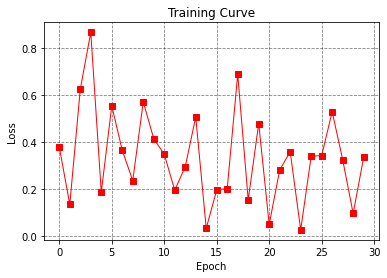

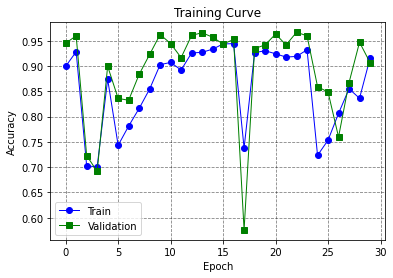

In [280]:
# increasing the hidden size
model_3 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 30,num_classes=2)
train_rnn_network(model_3,train,valid,30,1,num_epochs=30,learning_rate=0.001)

Epoch 1; Loss 0.861091; Train Acc 0.514138; Val Acc 0.132735
Epoch 2; Loss 0.743529; Train Acc 0.514138; Val Acc 0.132735
Epoch 3; Loss 0.641465; Train Acc 0.515978; Val Acc 0.140807
Epoch 4; Loss 0.734016; Train Acc 0.654509; Val Acc 0.527354
Epoch 5; Loss 0.649792; Train Acc 0.770119; Val Acc 0.848430
Epoch 6; Loss 0.406269; Train Acc 0.847917; Val Acc 0.919283
Epoch 7; Loss 0.273380; Train Acc 0.856282; Val Acc 0.888789
Epoch 8; Loss 0.365182; Train Acc 0.857955; Val Acc 0.934529
Epoch 9; Loss 0.263265; Train Acc 0.877363; Val Acc 0.938117
Epoch 10; Loss 0.318908; Train Acc 0.896938; Val Acc 0.939910
Epoch 11; Loss 0.343047; Train Acc 0.899448; Val Acc 0.904933
Epoch 12; Loss 0.159438; Train Acc 0.908315; Val Acc 0.921076
Epoch 13; Loss 0.156831; Train Acc 0.907646; Val Acc 0.930045
Epoch 14; Loss 0.536290; Train Acc 0.910825; Val Acc 0.913004
Epoch 15; Loss 0.175133; Train Acc 0.908984; Val Acc 0.947982
Epoch 16; Loss 0.330078; Train Acc 0.918856; Val Acc 0.934529
Epoch 17; Loss 0.

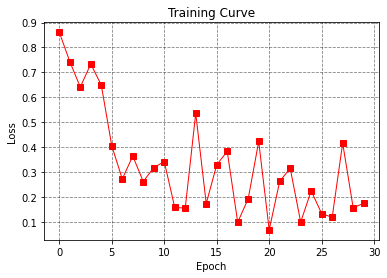

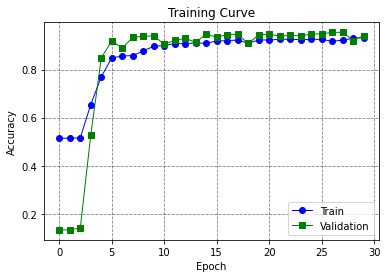

In [281]:
model_4 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 20,num_classes=2)
train_rnn_network(model_4,train,valid,20,1,num_epochs=30,learning_rate=0.0001)

Epoch 1; Loss 0.747178; Train Acc 0.530032; Val Acc 0.158744
Epoch 2; Loss 0.691680; Train Acc 0.646311; Val Acc 0.631390
Epoch 3; Loss 0.639263; Train Acc 0.692990; Val Acc 0.706726
Epoch 4; Loss 0.727924; Train Acc 0.745190; Val Acc 0.799103
Epoch 5; Loss 0.322536; Train Acc 0.874017; Val Acc 0.936323
Epoch 6; Loss 0.209488; Train Acc 0.904634; Val Acc 0.937220
Epoch 7; Loss 0.392856; Train Acc 0.918521; Val Acc 0.938117
Epoch 8; Loss 0.198675; Train Acc 0.898779; Val Acc 0.939910
Epoch 9; Loss 0.362678; Train Acc 0.938598; Val Acc 0.929148
Epoch 10; Loss 0.202492; Train Acc 0.910658; Val Acc 0.955157
Epoch 11; Loss 0.184022; Train Acc 0.929061; Val Acc 0.956054
Epoch 12; Loss 0.035674; Train Acc 0.885896; Val Acc 0.895964
Epoch 13; Loss 0.053864; Train Acc 0.919859; Val Acc 0.938117
Epoch 14; Loss 0.270482; Train Acc 0.934583; Val Acc 0.929148
Epoch 15; Loss 0.033014; Train Acc 0.937427; Val Acc 0.957848
Epoch 16; Loss 0.142796; Train Acc 0.937427; Val Acc 0.953363
Epoch 17; Loss 0.

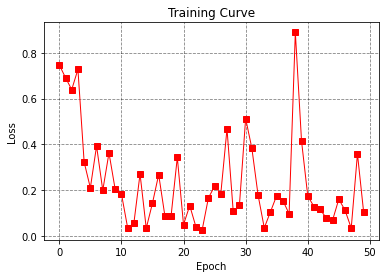

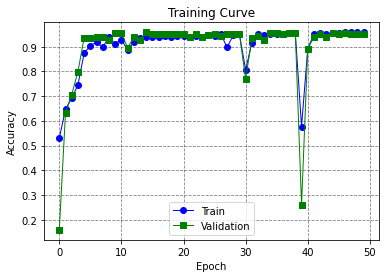

In [282]:
model_5 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 35,num_classes=2)
train_rnn_network(model_5,train,valid,35,1,num_epochs=50,learning_rate=0.0001)

Observation: Hidden layer size doesnt seem to affect the accuracy too much. So far with the hidden layer size of 10 and learning rate of 0.001 with 30 epochs we were able to get the best training and validation accuracy with less loss in training.

Epoch 1; Loss 0.526598; Train Acc 0.928679; Val Acc 0.959641
Epoch 2; Loss 0.115640; Train Acc 0.941843; Val Acc 0.955157
Epoch 3; Loss 0.060693; Train Acc 0.945842; Val Acc 0.960538
Epoch 4; Loss 0.138040; Train Acc 0.950508; Val Acc 0.965919
Epoch 5; Loss 0.174629; Train Acc 0.960007; Val Acc 0.963229
Epoch 6; Loss 0.066492; Train Acc 0.958674; Val Acc 0.968610
Epoch 7; Loss 0.018532; Train Acc 0.962673; Val Acc 0.965919
Epoch 8; Loss 0.101033; Train Acc 0.966839; Val Acc 0.974888
Epoch 9; Loss 0.108501; Train Acc 0.968005; Val Acc 0.974888
Epoch 10; Loss 0.015540; Train Acc 0.967505; Val Acc 0.967713
Epoch 11; Loss 0.045304; Train Acc 0.970505; Val Acc 0.975785
Epoch 12; Loss 0.020268; Train Acc 0.970838; Val Acc 0.976682
Epoch 13; Loss 0.179463; Train Acc 0.973338; Val Acc 0.974888
Epoch 14; Loss 0.015962; Train Acc 0.971338; Val Acc 0.978475
Epoch 15; Loss 0.179166; Train Acc 0.976671; Val Acc 0.970404
Epoch 16; Loss 0.023821; Train Acc 0.977837; Val Acc 0.966816
Epoch 17; Loss 0.

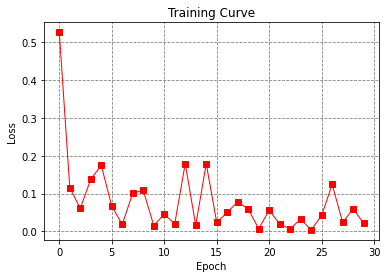

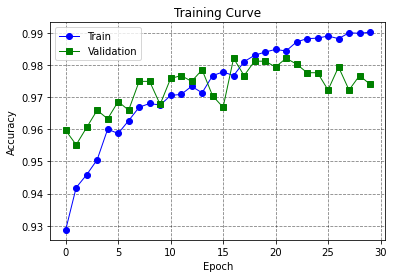

In [31]:
# trying maxpool at the output layer
model_6 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2,pooling=True,pool_type=1)
train_rnn_network(model_6,train,valid,10,2,num_epochs=30,learning_rate=0.001)

Observation: using the maxpool at the end of the network definitely has improved the performance. Checking the last method as average of maxpool and average pool

Epoch 1; Loss 2.293930; Train Acc 0.523507; Val Acc 0.144395
Epoch 2; Loss 1.916088; Train Acc 0.680274; Val Acc 0.779372
Epoch 3; Loss 1.821576; Train Acc 0.748369; Val Acc 0.896861
Epoch 4; Loss 1.694302; Train Acc 0.816463; Val Acc 0.915695
Epoch 5; Loss 1.626235; Train Acc 0.824661; Val Acc 0.930045
Epoch 6; Loss 1.572515; Train Acc 0.859796; Val Acc 0.943498
Epoch 7; Loss 1.631073; Train Acc 0.866823; Val Acc 0.946188
Epoch 8; Loss 1.607509; Train Acc 0.876527; Val Acc 0.948879
Epoch 9; Loss 1.503138; Train Acc 0.874854; Val Acc 0.950673
Epoch 10; Loss 1.466517; Train Acc 0.894094; Val Acc 0.956054
Epoch 11; Loss 1.521617; Train Acc 0.909821; Val Acc 0.961435
Epoch 12; Loss 1.572882; Train Acc 0.908483; Val Acc 0.961435
Epoch 13; Loss 1.539865; Train Acc 0.908483; Val Acc 0.962332
Epoch 14; Loss 1.460387; Train Acc 0.915342; Val Acc 0.964126
Epoch 15; Loss 1.552596; Train Acc 0.915509; Val Acc 0.965022
Epoch 16; Loss 1.441631; Train Acc 0.915175; Val Acc 0.965022
Epoch 17; Loss 1.

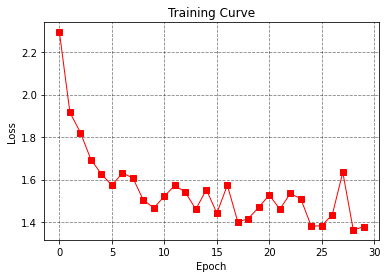

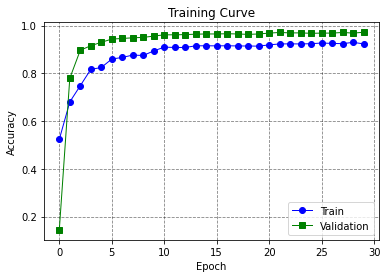

In [296]:
model_7 = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2,pooling=True,pool_type=2)
train_rnn_network(model_7,train,valid,10,3,num_epochs=30,learning_rate=0.001)

Observation: From the hyper-parameter tuning we can see that learning rate of 0.001 with 30 epochs and hidden layer size of 10 and using max pool at the end yeilded the best result.

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [32]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nonspam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [33]:
best_model = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2,pooling=True,pool_type=1)
best_model_path = get_model_name(best_model.name,32,0.001,29,10,2)
# model_path = "/content/model_sd_RNN_bs32_lr0.001_epoch28_hidden10_out2"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [78]:
spam_loader = torchtext.legacy.data.BucketIterator(valid_spam,
                                                    batch_size=1,
                                                    sort_key=lambda x: len(x.sms), # to minimize padding
                                                    sort_within_batch=True,        # sort within each batch
                                                    repeat=False)                  # repeat the iterator for many epochs
nonspam_loader = torchtext.legacy.data.BucketIterator(valid_nonspam,
                                                      batch_size=1,
                                                      sort_key=lambda x: len(x.sms), # to minimize padding
                                                      sort_within_batch=True,        # sort within each batch
                                                      repeat=False)                  # repeat the iterator for many epochs


https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

Observation: How often does it predicts it as spam when its a non spam message. {False Positive rate}. By the Accuracy formula we can get the TNR with the non spam dataset, therefore by subtracting with one we can get FPR.

False Negative rate, In the actual spam messages, how often the model predicts it as non spam message. (can be found by subtracting 1-TPR)


In [79]:
FPR = 1- get_accuracy(best_model,nonspam_loader)
FNR = 1- get_accuracy(best_model,spam_loader)
print(f"False Positive Rate is: {round(FPR,4)} and False Negative rate is: {round(FNR,4)}")

False Positive Rate is: 0.0185 and False Negative rate is: 0.0764


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

Ans: If the spam detection algorithm is deployed on my phone, i can say that based on the obtained result so far, the algorithm will be able to classify all the messages with FPR of 0.0185 (i.e, in 100 non spam messages, one or two message will be classified as spam) and approx seven or eight message of 100 spam message may be classified as non spam message (0.0764 FNR)

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [76]:
test_loader = torchtext.legacy.data.BucketIterator(test,
                                                   batch_size=1,
                                                   sort_key=lambda x: len(x.sms), # to minimize padding
                                                   sort_within_batch=True,        # sort within each batch
                                                   repeat=False)                  # repeat the iterator for many epochs

In [77]:
print(f"Final Test set accuracy is: {round(get_accuracy(best_model,test_loader),4)}")

Final Test set accuracy is: 0.9677


Observation: We were able to obtain 96.77% accuracy on the test dataset.

### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [38]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nonspam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [74]:
spam_loader_test = torchtext.legacy.data.BucketIterator(test_spam,
                                                        batch_size=1,
                                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                                        sort_within_batch=True,        # sort within each batch
                                                        repeat=False)                  # repeat the iterator for many epochs
nonspam_loader_test = torchtext.legacy.data.BucketIterator(test_nonspam,
                                                           batch_size=1,
                                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                                           sort_within_batch=True,        # sort within each batch
                                                           repeat=False)                  # repeat the iterator for many epochs

In [75]:
FPR_test = 1- get_accuracy(best_model,nonspam_loader_test)
FNR_test = 1- get_accuracy(best_model,spam_loader_test)
print(f"False Positive Rate is: {round(FPR_test,4)} and False Negative rate is: {round(FNR_test,4)}")

False Positive Rate is: 0.0178 and False Negative rate is: 0.1188


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [41]:
msg = "machine learning is sooo cool!"

In [42]:
msg_tensor = torch.tensor([text_field.vocab.stoi[i] for i in msg])
msg_tensor = torch.unsqueeze(msg_tensor,0)

In [43]:
output = best_model(msg_tensor)
print(f"The message is spam: {output.max(1, keepdim=True)[1] == 1}")
prob_spam = F.softmax(output,dim=1)[0][1]*100
print(f"Probability of message being spam: {round(prob_spam.item(),2)}%")

The message is spam: tensor([[False]])
Probability of message being spam: 1.58%


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Reference: https://bdtechtalks.com/2020/11/30/machine-learning-spam-detection/#:~:text=Spam%20detection%20is%20a%20supervised,data%20sets%20of%20labeled%20emails.


One of the best classifier for spam/ham detection is using Naive bayes classifier, we can use Bow for naively classifying, if the certain words are present in abundance in a message, the probability of the message being spam can be increased. Also, use of bigram and/or trigram can also increase the probabilty of the classification based on the dataset being used.

The words in the spam/ham messages are taken as Bow vectors and the matrix is given as input for the multinomial/binomial NB model in sklearn. Since its a supervised model, the output of the model after hyperparameter optimization can be compared with the labels to check for the accuracy of the model. [have to make sure the data is not biased] 

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [44]:
# install relevant libraries
!pip install fastai

In [45]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [46]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-23 14:11:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z 100%[===================>] 198.65K   730KB/s    in 0.3s    

2022-03-23 14:11:33 (730 KB/s) - ‘smsspamcollection.zip.1’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


This time we will load the data using pandas.

In [47]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [48]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [49]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [50]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [107]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [108]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the asking door is not closed until the lunch was
The problem usually starts when there is a change of local mood , and sometimes
The problem usually starts when there is a gap between the two top missing secret
The problem usually starts when jason is left either on his back and because he
The problem usually starts when Ibh takes care of a shop and has a


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [109]:
for i in range(3):
  print(lang_mod.predict("Danny is a", n_words=4))

Danny is a 2003 Indian
Danny is a free - calling short
Danny is a Missed Day


In [110]:
for i in range(5):
  print(lang_mod.predict("This movie is", n_words=5))

This movie is seen in the John
This movie is the first film in
This movie is an boring version , but
This movie is the most - played -
This movie is a part of The


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [111]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.560957,3.905977,0.285714,00:02
1,4.835441,3.940038,0.257143,00:02
2,4.378239,3.794564,0.242857,00:02
3,4.055073,3.774731,0.257143,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.604179,3.769687,0.285714,00:02
1,3.544720,3.707261,0.300000,00:02
2,3.488390,3.715145,0.300000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.392305,3.685590,0.285714,00:02
1,3.373453,3.680187,0.271429,00:02
2,3.358603,3.683583,0.285714,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.340693,3.702918,0.257143,00:03
1,3.293095,3.693171,0.285714,00:03
2,3.260172,3.686216,0.257143,00:03


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [112]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [113]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos a xxmaj boy loved a gal . xxmaj he xxunk bt she did nt mind . xxmaj he xxunk xxunk xxunk , xxmaj bt her frnds xxunk xxunk . xxmaj again d boy decided 2 xxunk d gal , xxunk time a xxunk was xxunk towards d gal . xxmaj xxunk it was about 2 hit d girl , d boy ran like hell n saved her . xxmaj",ham
"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < xxup decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : xxmaj sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - xxmaj maid",ham
"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj margaret xxmaj hello "" xxmaj she is",ham
"xxbos xxmaj you are everywhere xxunk , on the floor , the windows , even on my shirt . xxmaj and sometimes when i open my xxunk , you are all that comes xxunk out . i dream of my world without you , then half my xxunk are out too . a time of joy for me , lots of tv shows i.ll see . xxmaj but i guess",ham


In [114]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [115]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.51E-02


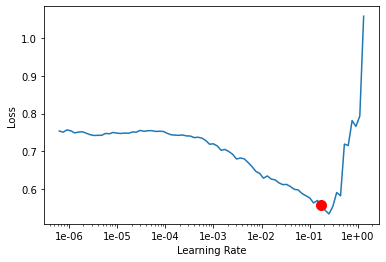

In [116]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [119]:
learn_classifier.fit_one_cycle(5, max_lr=1.74e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.513954,0.122507,0.981459,00:03
1,0.379145,0.136998,0.941986,00:03
2,0.300554,0.115665,0.977871,00:03
3,0.124181,0.093341,0.988636,00:03
4,0.113043,0.091824,0.979067,00:03


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

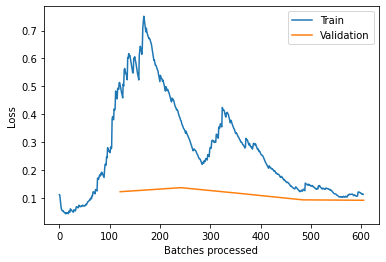

In [120]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 4.79E-03


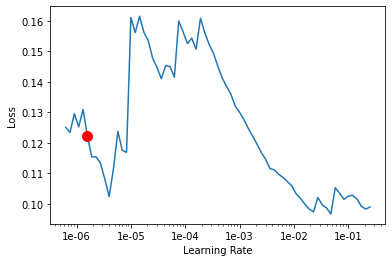

In [121]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [122]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9927e-01, 7.3270e-04]))

In [123]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.4275, 0.5725]))

Next we will evaluate on all of our validation data.

In [124]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [125]:
correct, total = 0,0
pred = valid_preds.max(1, keepdim=True)[1]
correct += pred.eq(valid_label.view_as(pred)).sum().item()
total += valid_label.shape[0]
print('Validation Accuracy of ULMFiT model is:',round(float(correct/total),4)*100,'%')

Validation Accuracy of ULMFiT model is: 97.91 %


Observation: Previously we got 97.3% on validaiton dataset and 96.6% on testing set but in this ULMFit model 97.91% accuracy was obtained. The model definitely is more or less on par with the RNN model prepared.

### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [126]:
conf_matrix = confusion_matrix(y_true=valid_label, y_pred=pred)

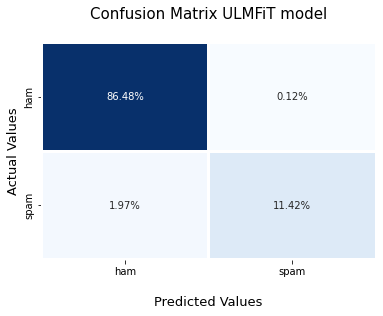

In [127]:
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',edgecolor='k', linewidth=2, zorder=3,cbar=False)

ax.set_title('Confusion Matrix ULMFiT model\n',size=15)
ax.set_xlabel('\nPredicted Values',size=13)
ax.set_ylabel('Actual Values',size=13)

ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])

plt.show()


In [71]:
best_model = sd_RNN(input_size = len(text_field.vocab),hidden_size = 10,num_classes=2,pooling=True,pool_type=1)
best_model_path = get_model_name(best_model.name,32,0.001,29,10,2)
# model_path = "/content/model_sd_RNN_bs32_lr0.001_epoch28_hidden10_out2"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

<All keys matched successfully>

In [72]:
test_batcher = torchtext.legacy.data.BucketIterator(test,
                                                    batch_size=1,
                                                    sort_key=lambda x: len(x.sms), # to minimize padding
                                                    sort_within_batch=True,        # sort within each batch
                                                    repeat=False) 

In [73]:
rnn_pred = []
rnn_act = []
for data, labels in test_batcher:
    output = best_model(data[0])
    pred = output.max(1, keepdim=True)[1]
    rnn_act.append(labels.item())
    rnn_pred.append(pred.item())


In [80]:
conf_matrix_rnn = confusion_matrix(y_true=rnn_act, y_pred=rnn_pred)

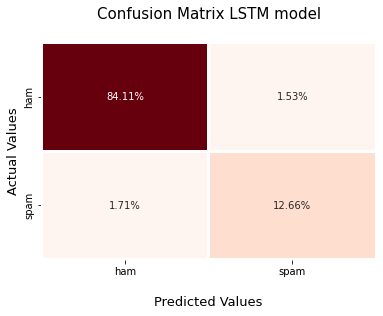

In [81]:
ax = sns.heatmap(conf_matrix_rnn/np.sum(conf_matrix_rnn), annot=True, 
            fmt='.2%', cmap='Reds',edgecolor='k', linewidth=2, zorder=3,cbar=False)

ax.set_title('Confusion Matrix LSTM model\n',size=15)
ax.set_xlabel('\nPredicted Values',size=13)
ax.set_ylabel('Actual Values',size=13)

ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])

plt.show()

Observation: From the result we can see that very slight difference between the LSTM and ULMFit model, ULMFit model was able to classify true positive and but not true negatives.

## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [135]:
msg = "machine learning is sooo cool!"
value = learn_classifier.predict(msg)
print(f"probability that the message is spam: {round(value[2][1].item(),4)*100}%")

probability that the message is spam: 0.0%


Observation: compared to the RNN model previously, the spam classification is more generalised, it was able to tell that the message was not spam with approx 100% confidence.

### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [154]:
def spam_ham_classification(text):
    value_ulmfit = learn_classifier.predict(text)
    msg_tensor_lstm = torch.tensor([text_field.vocab.stoi[i] for i in text])
    msg_tensor_lstm = torch.unsqueeze(msg_tensor_lstm,0)
    output_lstm = best_model(msg_tensor_lstm)
    prob_spam_lstm = F.softmax(output_lstm,dim=1)[0][1]*100
    print(f"Probability of message being spam from ULMFit model: {round(value_ulmfit[2][1].item()*100,2)}%")
    print(f"Probability of message being spam from LSTM model: {round(prob_spam_lstm.item(),2)}%")

In [162]:
spam_ham_classification("₹20,000 off* exchange offer, Loans at just 9.99%* & much more 😍 | Ola Cars Expo")

Probability of message being spam from ULMFit model: 1.91%
Probability of message being spam from LSTM model: 98.8%


In [156]:
spam_ham_classification("5000+ H1B Internships and Jobs, Start Applying! 🔥💯🚀")

Probability of message being spam from ULMFit model: 53.72%
Probability of message being spam from LSTM model: 98.38%


In [165]:
spam_ham_classification("Click here for £500 amazon gift card")

Probability of message being spam from ULMFit model: 78.16%
Probability of message being spam from LSTM model: 99.26%


In [158]:
spam_ham_classification("No Annual Charges, Get your lifetime free Axis Bank Credit Card Now")

Probability of message being spam from ULMFit model: 40.43%
Probability of message being spam from LSTM model: 0.16%


In [160]:
spam_ham_classification("Order Ola Dash's Holi special collection and get them home in 10 mins!")

Probability of message being spam from ULMFit model: 27.68%
Probability of message being spam from LSTM model: 77.82%


Observation: From the Spam mails, we can see that LSTM model performed really well overall. In first example we can see that LSTM probably fit offers and loans words as spam. Fourth example, eventhough it seems like a regular ham mail ULMFit was close to classifying it as spam.  

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [166]:
def ham_classification(text):
    value_ulmfit = learn_classifier.predict(text)
    msg_tensor_lstm = torch.tensor([text_field.vocab.stoi[i] for i in text])
    msg_tensor_lstm = torch.unsqueeze(msg_tensor_lstm,0)
    output_lstm = best_model(msg_tensor_lstm)
    prob_spam_lstm = F.softmax(output_lstm,dim=1)[0][0]*100
    print(f"Probability of message being ham from ULMFit model: {round(value_ulmfit[2][0].item()*100,2)}%")
    print(f"Probability of message being ham from LSTM model: {round(prob_spam_lstm.item(),2)}%")

In [167]:
ham_classification("Air Canada - 21 Apr 2022: Toronto - Chennai (Madras) (Booking Reference: 4RGAEQ) - Your booking has been modified")

Probability of message being ham from ULMFit model: 36.14%
Probability of message being ham from LSTM model: 86.68%


In [168]:
ham_classification("Your Metergy Bill is Now Available")

Probability of message being ham from ULMFit model: 92.27%
Probability of message being ham from LSTM model: 99.94%


In [169]:
ham_classification("INTERAC e-Transfer: SUPRIYA sent you money.")

Probability of message being ham from ULMFit model: 85.65%
Probability of message being ham from LSTM model: 99.63%


In [170]:
ham_classification("Credit card payment confirmation – A1B4C8D4E9F3G5H6I9J2")

Probability of message being ham from ULMFit model: 70.23%
Probability of message being ham from LSTM model: 0.11%


In [171]:
ham_classification("New Vacancies For data science unpaid intern")

Probability of message being ham from ULMFit model: 92.82%
Probability of message being ham from LSTM model: 99.79%


Observation: From the results obtained, we can see that ULMFit model has generalised properly and model was able to segreggate spam from non spam properly. The fourth example we can see that LSTM model has probably fit credit card information to being spam, thats probably why the model was not able to classify it as ham. However, UTMFit model was able to classify it properly.

Inference: LSTM model based on the given sample space, has overfit to the certain sequence of words, and ULMFit is not aggressive in classiying spam messages as non spam.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [172]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] WARNING | pattern 'LAB_4_Sequential_Data.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--e

CalledProcessError: ignored

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus